# Анализ A/B-теста для инвестиционного финтех-приложения 

## Контекст
Анализируется международное мобильное приложение для торговли финансовыми активами, ориентированное на рынок Латинской  
Америки.

## Проблема
Анализ исторических данных показал низкое удержание пользователей после покупки высокорискованных активов. Вероятная  
причина - недостаточная финансовая грамотность, которая приводит к потере денег и снижению вовлеченности.

## Гипотеза
Внедрение в онбординг обучающего блока о рисках повысит осознанность пользователей, что приведет к росту удержания  
(retention) и повторных депозитов.

## Дизайн эксперимента
- **Цель:** Оценить влияние обновленного онбординга на инвестиционную активность пользователей.
- **Группы:** Контрольная (старый онбординг) и Тестовая (новый онбординг).
- **Период:** Новые пользователи, зарегистрировавшиеся со 2 по 15 июня 2025 года.
- **Ключевые метрики:**
  - **Основная:** ARPU (средняя сумма всех депозитов на пользователя).
  - **Барьерная:** CR из регистрации в первый депозит.
  - **Вспомогательные:** CR из первого во второй депозит, ARPPU (средняя сумма депозитов на платящего).

## Описание данных
Для анализа использовались два датасета (hist.csv, abt.csv): исторические данные (апрель-июнь 2025) и результаты  
A/B-теста (2-15 июня 2025).

Общие поля датасетов:
- `user_id` - уникальный идентификатор пользователя
- `country_code` - код страны пользователя в формате ISO
- `platform` - устройство, с которого пользователь взаимодействует с продуктом: mobile или web
- `first_ts` - время первого появления пользователя в системе
- `first_dt` - дата первого появления пользователя (без времени)
- `event_ts` - время события
- `event_name` - название события
- `amount` - сумма пополнения депозита
- `asset` - тип приобретённого актива 
- `risk_level` - уровень риска актива: low - низкий риск, medium - средний риск, high - высокий риск.

В датасете abt.csv содержатся два дополнительных поля:
- `ab_test` - название А/В-эксперимента;
- `group` - пользовательская группа А/В-эксперимента.


### Этапы работы
1. Загрузка исторических данных и их предобработка
2. Исследовательский анализ исторических данных
3. Исследование результатов А/В эксперимента
4. Анализ изменений суммы депозитов на платящего пользователя
5. Выводы

---


In [29]:
# При необходимости решает проблему с устаревшим функционалом на платформе  
# (отсутствует bar_plot) и конфликтом версий 

# %pip install numpy==1.23.5
# %pip install pandas==1.5.3
# %pip install matplotlib==3.7.0
# %pip install seaborn==0.12.2
# %pip install scipy==1.10.1
# %pip install numba==0.57.0

In [ ]:
%pip install numpy pandas statsmodels matplotlib seaborn scipy numba ipython requests tqdm tabulate matplotlib_venn -q 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Импортируем библиотеки

# Работа с данными
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype

# Визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

# стат
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import TTestIndPower

# Вспомогательные импорты
from IPython.display import Markdown, display, HTML
import io
from tqdm import tqdm

In [4]:
# Зададам стили и настройки форматирования 
display(HTML("""<style>.output_area{max-height: none !important;}
             h1{color:#D14D41;}h2{color:#DA702C;}h3{color:#D0A215;}
             h4{color:#879A39;}h5{color:#3AA99F;}h6{color:#4385BE;}
             </style>"""))

# Зададим некоторую произвольную палитру для графиков
pal = [
    '#C9495E',  '#50C2E5', '#38A86F',  '#D466A0', 
    "#956BBE",  "#0B8C9E", "#EAD38C",  '#17BECF'
]

# цвета групп
color_A, color_B = '#87ceeb', '#ffa07a'

# полезные функции

# ------------------------------------------------------------------------------
# Расширенная информация о данных
# выводит процент нулей, чтобы не прикидывать в уме сколько там нулей? 
# 4.73% или 8.19%?🤔 Это уже достаточно много чтобы не игнорировать или еще нет?
def extended_info(df):
    buf = io.StringIO()
    df.info(buf=buf)
    info_lines = buf.getvalue().splitlines()
    rn = info_lines[1].split()[1] # rows number
    
    cols = ['Name',  'Non-Null', 'Null', 'Null share', 'Dtype']

    data = [
        [' '.join(x[1:-3]), x[-3], int(rn) - int(x[-3]), 
         f'{round((int(rn) - int(x[-3]))*100 / int(rn) , 2)}%',  x[-1]]
        for row in info_lines[5:-2]
        for x in [row.split()]
    ]
    
    meta = [
        [f'**{x[0]}**', f'**{x[1]}**'] + ['']*(len(cols)-2) 
        for row  in info_lines[-2:] 
        for x  in [row.split(': ')]
    ]
    
    data += meta
    return Markdown(pd.DataFrame(data, columns=cols).to_markdown())

# простая проверка на наличие явнях дубликатов
def check_exp_dups(data, cols_subset):
    # проверим на наличиие полных дубликатов
    full_dups = data.duplicated().sum()
    print(f"Количество явных дубликатов по всем полям: {full_dups.sum()}")

    #  проверим на наличиие дубликатов по отдельным столбцам
    subset_dups = data.duplicated(subset=cols_subset)
    print(f"Количество явных дубликатов заданному набору полей: {subset_dups.sum()}")
     
# ------------------------------------------------------------------------------
# уникальные значения категориальных признаков
# решает проблему неявного дублирования данных. 
# - Пример вывели уники в поле город   
#     Санкт-Петербург  
#     Санкт Петербург (без дефиса)  
#     Санкт-Петербуг (опечатка)  
#     СПб (аббревиатура)  
# - сразу видно что есть неявные дубликаты  
# - **удобно**: ввел все кат. столбцы - получил на выходе уникальные значения 
# **сразу по ВСЕМ столбцам в одной таблице**
def get_df_unique_values(df, cols=None, row_count=20, _sorted=True):
    new_cols = dict()
    
    if cols is None:
        cols = df.columns.tolist()
    
    for col in cols:
        u_vals = sorted(df[col].unique()) if _sorted else df[col].unique()
        
        if len(u_vals) > row_count:
            for i in range(0, len(u_vals), row_count):
                col_name = f"{col}_{i // row_count + 1}"  
                
                chnk = pd.Series(u_vals[i:i + row_count]).reset_index(drop=True)
                padded = chnk.reindex(range(row_count), fill_value='')
                
                new_cols[col_name] = padded
        else:
            padded = pd.Series(u_vals).reindex(range(row_count), fill_value='')
            new_cols[col] = padded.reset_index(drop=True)
            
    new_df = pd.DataFrame(new_cols)
    return new_df


# ------------------------------------------------------------------------------
# гистограмма и ящик с усами
# - просто строит гистограмму и ящик с усами. 
# - **удобно**: не надо каждый раз думать про детали реализации - просто передал
# параметры и построил график
def plot_hist_and_boxplot(data_series, title, xlabel, ylabel, bins=30,
                          whis=1.5, figsize=(10, 6),
                          color='lightgray', edgecolor='grey', log_scale=False,
                          lims=None, percentiles=None):
    """
    Функция строит гистограмму и ящик с усами для указанного столбца.
    """

    fig, axs = plt.subplots(2, 1, figsize=figsize)

    # Store x-axis limits before plotting the boxplot

    sns.histplot(data_series, ax=axs[0], bins=bins, alpha=0.7, color=color, 
                 edgecolor=edgecolor, kde=True, log_scale=log_scale)


    axs[0].set_xlabel(xlabel[0])
    axs[0].set_ylabel(ylabel[0])
    # axs[0].set_title("Histogram")
    if lims:
        axs[0].set_xlim(lims[0])

    # перцентили
    if percentiles:
        perc_values = np.percentile(data_series, percentiles)
        
        # Получаем верхнюю границу оси Y для размещения текста
        y_max = axs[0].get_ylim()[1] 
        
        for p_val, p in zip(perc_values, percentiles):
            # Рисуем линию
            axs[0].axvline(p_val, color='indianred', linestyle='--')
            axs[1].axvline(p_val, color='indianred', linestyle='--')
            
            # Добавляем текст над линией
            axs[0].text(p_val, y_max, f' {p}% \n({p_val:.1f})', 
                        color='indianred', ha='left', va='bottom')
                
    # Boxplot plot
    if log_scale:
         axs[1].set_xscale('log')  # Apply log scale to boxplot BEFORE boxplot
         xmin, xmax = axs[0].get_xlim()
         axs[1].set_xlim(xmin, xmax)
    else:
         xmin, xmax = axs[0].get_xlim()
         axs[1].set_xlim(xmin, xmax)

    axs[1].boxplot(data_series, vert=False, whis=whis)
    axs[1].set_xlabel(xlabel[1])
    axs[1].set_ylabel(ylabel[1])
    axs[1].set_yticks([])  
    # axs[1].set_title("Boxplot")
    fig.suptitle(title)
    # fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
    
        # Немного увеличиваем отступ сверху, чтобы текст поместился
    # fig.tight_layout(rect=[0, 0.03, 1, 1.93]) 

    plt.show()


# ------------------------------------------------------------------------------
# столбчатая диаграмма для сравнения размеров групп (control и test).
# строит 2 столбца - тест, контроль, показывает разницу в процентах
def plot_group_comparison_bar( data: pd.Series, title: str, 
                              ylabel: str, fig_size: tuple = (8,6), 
                              colors: tuple = ('#87ceeb', '#ffa07a')
):
        
    control_val = data.iloc[0]
    test_val = data.iloc[1]
    
    # считаем процентную разницу
    diff_percent = (test_val - control_val) / control_val * 100
    
    # --- Построение графика ---
    plt.figure(figsize=fig_size)
    bars = plt.bar(data.index, data.values, color=colors, width=0.4)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Группа')
    
    
    # 1. Основные метки (абсолютные значения)
    plt.bar_label(bars, fmt='%.0f', padding=3)
    
    # 2. Метка с процентной разницей для тестовой группы
    #    (располагаем ее чуть выше основной метки)
    y_pos = bars[1].get_height()
    offset = bars[1].get_height() * 0.07 # динамический отступ
    
    plt.text(
        x=bars[1].get_x() + bars[1].get_width() / 2, # по центру столбца
        y=y_pos + offset,                            # чуть выше столбца
        s=f'({diff_percent:+.1f}%)',                 # текст метки
        ha='center',
        color='red' if diff_percent < 0 else 'green'
    )
    
    # добавляем немного места сверху
    plt.ylim(0, max(control_val, test_val) * 1.2)
    # отодвигаем столбцы от краев
    plt.xlim(-0.5, 1.5)



### 1. Загрузка исторических данных и их предобработка

> **Загрузка данных**
>
> Исходные данные были загружены из двух CSV-файлов:
> - `hist.csv` — исторические данные о поведении пользователей.
> - `abt.csv` — данные A/B-эксперимента.
> и сохранены в словарь `ds` с ключами `hist`, `abt`
>
> В процессе загрузки столбцы с датами были сразу приведены к формату `datetime`.
>
> ⚠️*Примечание: в соответствии с политикой конфиденциальности, код загрузки и сами файлы данных удалены из публичной*  
*версии проекта*

In [ ]:
# Выводим расширенную информацию о данных
for name, dataset in ds.items():
    display(Markdown(f'#### {name}'))
    display(extended_info(dataset))
    display(dataset.head())

#### hist

|    | Name             | Non-Null                                     | Null   | Null share   | Dtype          |
|---:|:-----------------|:---------------------------------------------|:-------|:-------------|:---------------|
|  0 | user_id          | 238059                                       | 0      | 0.0%         | object         |
|  1 | country_code     | 238059                                       | 0      | 0.0%         | object         |
|  2 | platform         | 238059                                       | 0      | 0.0%         | object         |
|  3 | first_ts         | 238059                                       | 0      | 0.0%         | datetime64[ns] |
|  4 | first_dt         | 238059                                       | 0      | 0.0%         | datetime64[ns] |
|  5 | event_ts         | 238059                                       | 0      | 0.0%         | datetime64[ns] |
|  6 | event_name       | 238059                                       | 0      | 0.0%         | object         |
|  7 | amount           | 33093                                        | 204966 | 86.1%        | float64        |
|  8 | asset            | 15392                                        | 222667 | 93.53%       | object         |
|  9 | risk_level       | 15392                                        | 222667 | 93.53%       | object         |
| 10 | **dtypes**       | **datetime64[ns](3), float64(1), object(6)** |        |              |                |
| 11 | **memory usage** | **18.2+ MB**                                 |        |              |                |

,user_id,country_code,platform,first_ts,first_dt,event_ts,event_name,amount,asset,risk_level
0,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 19:55:51,install / open_web,NaN,NaN,NaN
1,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 19:55:59,introduction,NaN,NaN,NaN
2,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 23:46:06,registration,NaN,NaN,NaN
3,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 23:46:15,main_page,NaN,NaN,NaN
4,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 23:47:59,onboarding_complete,NaN,NaN,NaN


#### abt

|    | Name             | Non-Null                                     | Null   | Null share   | Dtype          |
|---:|:-----------------|:---------------------------------------------|:-------|:-------------|:---------------|
|  0 | user_id          | 54805                                        | 0      | 0.0%         | object         |
|  1 | country_code     | 54805                                        | 0      | 0.0%         | object         |
|  2 | platform         | 54805                                        | 0      | 0.0%         | object         |
|  3 | first_ts         | 54805                                        | 0      | 0.0%         | datetime64[ns] |
|  4 | first_dt         | 54805                                        | 0      | 0.0%         | datetime64[ns] |
|  5 | event_ts         | 54805                                        | 0      | 0.0%         | datetime64[ns] |
|  6 | event_name       | 54805                                        | 0      | 0.0%         | object         |
|  7 | ab_test          | 54805                                        | 0      | 0.0%         | object         |
|  8 | group            | 54805                                        | 0      | 0.0%         | object         |
|  9 | amount           | 7843                                         | 46962  | 85.69%       | float64        |
| 10 | asset            | 3750                                         | 51055  | 93.16%       | object         |
| 11 | risk_level       | 3750                                         | 51055  | 93.16%       | object         |
| 12 | **dtypes**       | **datetime64[ns](3), float64(1), object(8)** |        |              |                |
| 13 | **memory usage** | **5.0+ MB**                                  |        |              |                |

,user_id,country_code,platform,first_ts,first_dt,event_ts,event_name,ab_test,group,amount,asset,risk_level
0,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-07 19:55:51,install / open_web,onboarding_test,test,NaN,NaN,NaN
1,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-07 19:55:54,introduction,onboarding_test,test,NaN,NaN,NaN
2,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-08 06:18:09,registration,onboarding_test,test,NaN,NaN,NaN
3,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-08 06:18:13,main_page,onboarding_test,test,NaN,NaN,NaN
4,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-08 06:33:40,onboarding_complete,onboarding_test,test,NaN,NaN,NaN



**hist**
- количество строк 238059
- пропуски в полях 
    - `amount` - 86.1% (204966), 
    - `asset` - 93.53% (222667), 
    - `risk_level` - 93.53% (222667)
- все названия признаков представлены в удобном формате 
- признаки имеют правильные форматы данных

**abt**
- количество строк 54805
- пропуски в полях 
    - `amount` - 85.69%	(46962), 
    - `asset` - 93.16%	(51055), 
    - `risk_level` - 93.16%	(51055)
- все названия признаков представлены в удобном формате 
- признаки имеют правильные форматы данных


**Событие `install / open_web` было переименовано в `install__open_web` для удобства обработки.**


In [6]:
for key, df in ds.items():
    df['event_name'] = df['event_name'].str.replace('install / open_web', 'install__open_web', regex=False)

#### Рассмотрим распределение пропусков по событиям
примерный порядок событий

- 1	install__open_web - Установка или открытие сайта
- 2	registration - Регистрация аккаунта
- 3 introduction - Вводное обучение, onboarding
- 4	onboarding_complete - Завершение онбординга
- 5	main_page - Посещение главной страницы
- 6	first_deposit - Первый депозит
- 7	asset_purchase - Покупка активов
- 8 second_deposit - Второй и последующие депозиты
- 9	asset_purchase - Покупка активов

In [7]:
# опрделим примерный порядок событий (убрали 9 пункт)
events_order = [ 'install__open_web', 'registration', 'introduction', 
                'onboarding_complete', 'main_page', 'first_deposit', 
                'asset_purchase', 'second_deposit']

# посчитаем не нулевые значения 
for name, dataset in ds.items():
    # НЕ нули
    evt_notna = dataset.iloc[:, -3:].notnull().groupby(dataset['event_name']).sum()

    evt_notna = evt_notna.reindex(events_order)

    # добавим полное кол-во строк
    evt_notna['total_rows'] = dataset['event_name'].value_counts()

    # выводим
    display(Markdown(f'#### {name}'))
    display(Markdown(evt_notna.to_markdown()))

#### hist

| event_name          |   amount |   asset |   risk_level |   total_rows |
|:--------------------|---------:|--------:|-------------:|-------------:|
| install__open_web   |        0 |       0 |            0 |        41032 |
| registration        |        0 |       0 |            0 |        38133 |
| introduction        |        0 |       0 |            0 |        41032 |
| onboarding_complete |        0 |       0 |            0 |        34337 |
| main_page           |        0 |       0 |            0 |        35040 |
| first_deposit       |    27685 |       0 |            0 |        27685 |
| asset_purchase      |        0 |   15392 |        15392 |        15392 |
| second_deposit      |     5408 |       0 |            0 |         5408 |

#### abt

| event_name          |   amount |   asset |   risk_level |   total_rows |
|:--------------------|---------:|--------:|-------------:|-------------:|
| install__open_web   |        0 |       0 |            0 |         9415 |
| registration        |        0 |       0 |            0 |         8777 |
| introduction        |        0 |       0 |            0 |         9415 |
| onboarding_complete |        0 |       0 |            0 |         7525 |
| main_page           |        0 |       0 |            0 |         8080 |
| first_deposit       |     6215 |       0 |            0 |         6215 |
| asset_purchase      |        0 |    3750 |         3750 |         3750 |
| second_deposit      |     1628 |       0 |            0 |         1628 |

Из обоих таблиц видно, что  
    - в первых 5 событиях ('install__open_web', 'registration', 'introduction', 'onboarding_complete', 'main_page')  
    вообще нет ненулевых значений в полях `amount`,`asset`, `risk_level`.  
    - но их и не должно быть, потому что до внесения денег на счет пользователь не может купить активы.  
    - в событиях first_deposit и second_deposit ненулевые значения только в поле `amount` - это сумма пополнения счета  
    остальные поля относятся к активам.  
    - событие asset_purchase содержит только поля, которые относятся к активам - asset и risk_level

**Таким образом, все пропуски в данных не являются ошибками и объясняются организацией структуры данных**

#### Проверим данные на наличие дубликатов

In [8]:

unique_cols = ['user_id', 'event_ts', 'event_name']
cat_cols = ['country_code','platform','event_name','asset','risk_level']

# проверим наличе дубликатов
for name, dataset in ds.items():
    display(Markdown(f'#### {name}'))
    
    # простая проверка на наличие явных дубликатов 
    check_exp_dups(dataset, unique_cols)
    print(unique_cols, '\n\n')
    
    # добавим поля для 2-го датасета 
    cat_cols += [] if name == 'hist' else ['ab_test', 'group']
    
    # проверим написание категориальных полей 
    # (что НЕявных дублей из-за ошибок написания ) 
    print("Уникальные значения категориальных признаков")
    print(cat_cols,'\n\n')
    
    display(get_df_unique_values(dataset, cols=cat_cols, row_count=10, _sorted=False))

#### hist

Количество явных дубликатов по всем полям: 0
Количество явных дубликатов заданному набору полей: 0
['user_id', 'event_ts', 'event_name'] 


Уникальные значения категориальных признаков
['country_code', 'platform', 'event_name', 'asset', 'risk_level'] 




,country_code,platform,event_name,asset,risk_level
0,BR,mobile,install__open_web,NaN,NaN
1,AR,web,introduction,stock,medium
2,CO,,registration,option,high
3,MX,,main_page,crypto,low
4,,,onboarding_complete,,
5,,,first_deposit,,
6,,,asset_purchase,,
7,,,second_deposit,,
8,,,,,
9,,,,,


#### abt

Количество явных дубликатов по всем полям: 0
Количество явных дубликатов заданному набору полей: 0
['user_id', 'event_ts', 'event_name'] 


Уникальные значения категориальных признаков
['country_code', 'platform', 'event_name', 'asset', 'risk_level', 'ab_test', 'group'] 




,country_code,platform,event_name,asset,risk_level,ab_test,group
0,BR,mobile,install__open_web,NaN,NaN,onboarding_test,test
1,MX,web,introduction,crypto,high,,control
2,CO,,registration,stock,low,,
3,AR,,main_page,option,medium,,
4,,,onboarding_complete,,,,
5,,,first_deposit,,,,
6,,,asset_purchase,,,,
7,,,second_deposit,,,,
8,,,,,,,
9,,,,,,,


- полных явных дубликатов нет 
- явных дубликатов по ключевым полям нет
- ошибок написания кат. признаков нет - неявных дубликатов не обнаружено

**Дубликатов не найдено**

---

### 2. Исследовательский анализ исторических данных

#### 2.1. Динамика привлечения новых пользователей

Новых пользователей будем определять по событию 'install / open_web'.
<!-- - 1	install / open_web - Установка или открытие сайта
- 2	registration - Регистрация аккаунта
- 3 introduction - Вводное обучение, onboarding
- 4	onboarding_complete - Завершение онбординга
- 5	main_page - Посещение главной страницы
- 6	first_deposit - Первый депозит
- 7	asset_purchase - Покупка активов
- 8 second_deposit - Второй и последующие депозиты
- 9	asset_purchase - Покупка активов
- ... -->

(238059, 10)
(41032, 10)


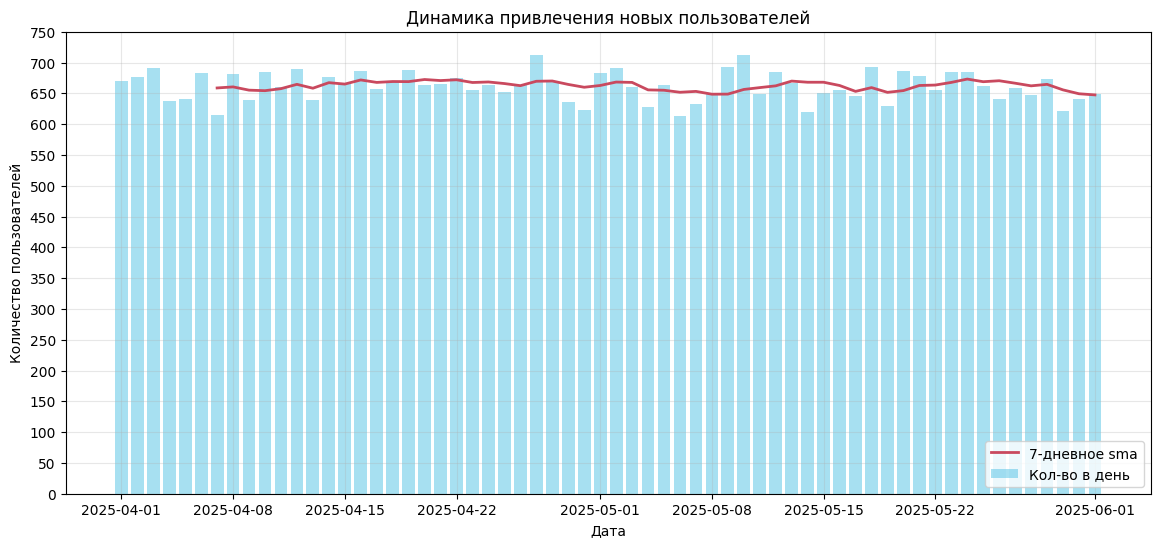

In [9]:
# упростим обращение к данным
hist, abt = ds['hist'], ds['abt']

# фильтруем первый контакт
print(hist.shape)
first_touch =  hist[hist['event_name']=='install__open_web'].copy()
print(first_touch.shape)

# новые пользователи
newcomers = first_touch.groupby('first_dt')['user_id'].nunique().reset_index(name='usr_cnt')

# среднее значение в неделю
newcomers['sma'] = newcomers['usr_cnt'].rolling(window=7).mean()
# График
plt.figure(figsize=(14, 6))
plt.bar(newcomers['first_dt'].values, newcomers['usr_cnt'].values, color=pal[1], alpha=0.5, label='Кол-во в день')
plt.plot(newcomers['first_dt'].values, newcomers['sma'].values, color=pal[0], lw=2, label='7-дневное sma')
plt.title('Динамика привлечения новых пользователей')
plt.xlabel('Дата')
plt.yticks(np.arange(0, 800, 50))
plt.ylabel('Количество пользователей')
plt.grid(alpha=0.3)
plt.legend(loc='lower right')
plt.show()


Из графика исторических данных видно, что
- динамика привлечения новых пользователей очень стабильная
- среднее значение держится около 660 пользователей в день
- размах значений лежит в диапазоне примерно от 610 до 710 человек 

#### 2.2. Анализ воронки событий

**Методология построения воронки**

Первичный анализ показал, что пользовательский путь в приложении нелинейный, что приводило к некорректному расчету  
пошаговой воронки (конверсия на некоторых этапах превышала 100%). Для построения корректной модели были приняты   
следующие допущения:

- Под "депозитом" понимается единичное пополнение счета.
- Пользователи могут приобретать активы только после первого депозита.
- При расчете пошаговой воронки на каждом этапе учитывались только те пользователи, которые прошли предыдущий шаг.

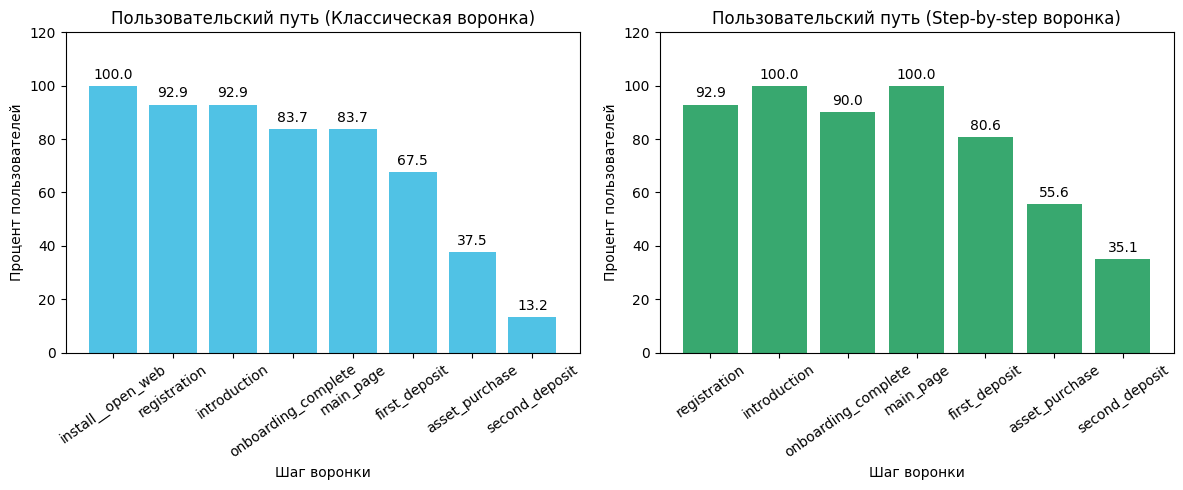

In [10]:
# шаги воронки 
fun_steps = [ 'install__open_web', 'registration', 'introduction', 
                'onboarding_complete', 'main_page', 'first_deposit', 
                'asset_purchase', 'second_deposit']

# добавляем дату
hist['event_dt'] =  hist['event_ts'].dt.normalize()

# сортируем данные
hist_sorted = hist.sort_values(['user_id', 'event_ts'])

# фильтруем по шагам
fun_step_data = hist_sorted[hist_sorted['event_name'].isin(fun_steps)]

# ------------------------------------------------------------------------------
# пользовательский путь нелинейный - поэтому воронку  
# считаем, фильтруя пользователей пришедших с предществующего шага
prev_step_ids = set(fun_step_data['user_id'])
step_ids = {}
for idx in range(0, len(fun_steps)):
        
    this_step_ids  = set(
        fun_step_data[
            (fun_step_data['event_name'] == fun_steps[idx]) &
            (fun_step_data['user_id'].isin(prev_step_ids))
        ]['user_id']
    )
    step_ids[fun_steps[idx]] = len(this_step_ids)
    prev_step_ids = this_step_ids
    
funnel = pd.DataFrame(step_ids.items(), columns=['step', 'usr_cnt'])

# классич.
funnel['cr_from_first'] = funnel.loc[:, 'usr_cnt'] *100 / \
                            funnel.loc[0, 'usr_cnt']

# step by step   
funnel['cr_from_prev'] = funnel.loc[:, 'usr_cnt'] *100 / \
                            funnel.shift(1)['usr_cnt']

# ------------------------------------------------------------------------------
# строии графики
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, (met,title) in enumerate([('cr_from_first', 'Классическая'),
                                ('cr_from_prev', 'Step-by-step')]):
    bars = ax[i].bar(funnel['step'], funnel[met], color=pal[i+1])
    ax[i].set_title(f'Пользовательский путь ({title} воронка)')
    ax[i].set_xlabel('Шаг воронки')
    ax[i].set_ylabel('Процент пользователей')
    ax[i].bar_label(bars, fmt='%.1f', padding=3)
    ax[i].tick_params(axis='x', labelrotation=35)
    ax[i].set_ylim(0, 120)

plt.tight_layout()
plt.show()

**Анализ пользовательского пути**
- обе воронки, классическая и пошаговая, показывают серьезное снижение на этапах 
    - `first_deposit` 
    - `asset_purchase`   
    - `second_deposit`  
- и если  глядя на пошаговую воронку можно еще как-то объяснить снижение на ~20% на шаге `first_deposit`, то   
просадка на 45% и 65% на этапах `asset_purchase` и `second_deposit`уже не выглядит разумной
- предположение о снижении вовлеченности пользователей из-за потери средств вследствие рискованной бездумной торговли   
выглядит правдоподобным.

#### 2.3. Влияние уровня риска на конверсию во второй депозит

Количество пользователей до фильтрации 238059
Количество пользователей после фильтрации 27685


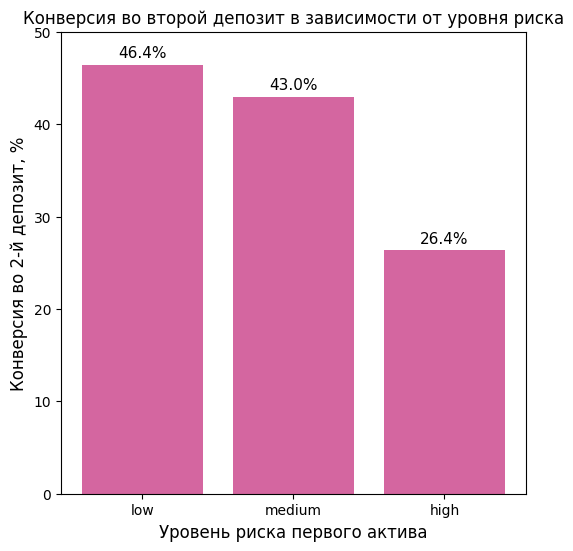

In [11]:
# находим всех у кого есть первый депозит
print('Количество пользователей до фильтрации', hist_sorted.shape[0])
first_depo_ids = hist[hist['event_name'] == 'first_deposit']['user_id']
print('Количество пользователей после фильтрации', first_depo_ids.shape[0])

filtered = hist[hist['user_id'].isin(first_depo_ids)]

# находим уровень риска пользователя  
user_rl = (
    filtered[filtered['event_name'] == 'asset_purchase']
    .groupby('user_id')['risk_level']
    .first()
    .reset_index()
    .rename(columns={'risk_level': 'user_risk_level'})
)
user_risk = hist.merge(user_rl, how='left', on='user_id')

# группируем пользователей по риску и считаем кол-во
risk_group_cnt = (
    user_risk
    .groupby(['event_name', 'user_risk_level'])['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'usr_cnt'})
)

# переформатиурем таблицу для удобства 
risk_pt = risk_group_cnt.pivot(
    columns=['event_name'],
    index='user_risk_level',
    values= 'usr_cnt'
).reset_index()

# считаем конверсию
risk_pt['cr_pct'] = 100 * risk_pt['second_deposit'] / risk_pt['first_deposit']

# сделаем сортировку по риску
risk_order = ['low', 'medium', 'high']
cat_type = CategoricalDtype(categories=risk_order, ordered=True)
risk_pt['user_risk_level'] = risk_pt['user_risk_level'].astype(cat_type)
risk_pt = risk_pt.sort_values('user_risk_level')

# строим график
plt.figure(figsize=(6, 6))
bars =plt.bar(risk_pt['user_risk_level'], risk_pt['cr_pct'], color=pal[3])
plt.title('Конверсия во второй депозит в зависимости от уровня риска')
plt.xlabel('Уровень риска первого актива', fontsize=12)
plt.ylabel('Конверсия во 2-й депозит, %', fontsize=12)
plt.bar_label(bars, fmt='%.1f%%', padding=3, fontsize=11)
plt.ylim(0, 50) 
plt.show()

**Анализ показал сильную зависимость между уровнем риска первого купленного актива и конверсией во второй депозит.**
- конверсия пользователей низкого (low) и среднего (medium) риска отличается на несколько процентов - 46.4% и 43%
- конверсия пользователей высокого (high) риска существенно ниже - 26.4%

Это подтверждает гипотезу о том, что неопытные пользователи, сталкиваясь с убытками от высокорискованных активов,  
теряют интерес к продукту.

#### 2.4. Анализ ключевой метрики (ARPU) на исторических данных

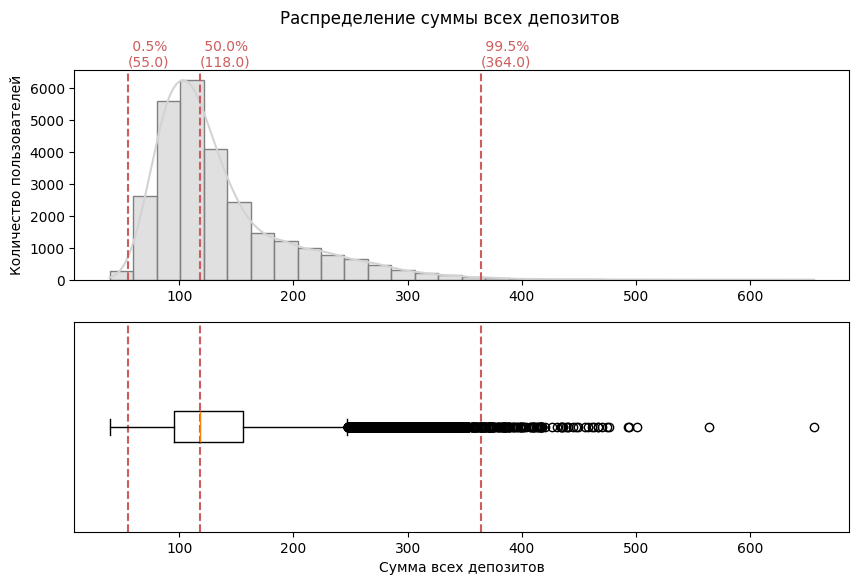


Все пользователи
- Ключевая метрика ARPU: 91.56

Платящие
- Среднее (ARPPU): 135.70
- Стандартное отклонение: 59.90
- Медиана: 118.00
- 99% платящих находится в диапазоне от 55 до 364  (процентили [0.5, 99.5])




In [12]:
depos_amnt = (
    hist[hist['user_id'].isin(first_touch['user_id'])]
    .groupby('user_id')['amount']
    .sum()
    .reset_index()
)

# ключевая метрика ARPU (на всех пользователях)
total_deposits = depos_amnt['amount'].sum()
total_users = first_touch['user_id'].nunique()
arpu = total_deposits / total_users

# платящие 
payers_amounts = depos_amnt[depos_amnt['amount'] > 0]['amount']
arppu = payers_amounts.mean()
std_dev = payers_amounts.std()
median = payers_amounts.median()

# строим график
plot_hist_and_boxplot(
    payers_amounts,
    'Распределение суммы всех депозитов',
    [None, 'Сумма всех депозитов'], 
    ['Количество пользователей', None], 
    log_scale=False,
    percentiles=[0.5, 50., 99.5])


# выводим
print(f"""
Все пользователи
- Ключевая метрика ARPU: {arpu:.2f}

Платящие
- Среднее (ARPPU): {arppu:.2f}
- Стандартное отклонение: {std_dev:.2f}
- Медиана: {median:.2f}
- 99% платящих находится в диапазоне от 55 до 364  (процентили [0.5, 99.5])

""")

Ключевая метрика ARPU (среднее **на всех** пользователей) составляет 91.56.

Распределение сумм среди **платящих** пользователей:
- среднее значение (ARPPU) составляет 135.70
- стандартное отклонение-59.90.
- Распределение **сильно скошено вправо**. 
    - большое стандартное отклонение - значительный разброс сумм и выбросы
    - медианный суммарный депозит (118.00) гораздо ниже среднего (135.70)
- Основная масса платящих пользователей (99%) вносит депозиты на общую сумму в диапазоне от 55 (0.5 перцентиль) до 364  
(99.5 перцентиль).


---
### 3. Исследование результатов А/В эксперимента

#### 3.1. Анализ корректности сплитования и аудитории эксперимента

'Размер группы A: 4847'

'Размер группы B: 4568'

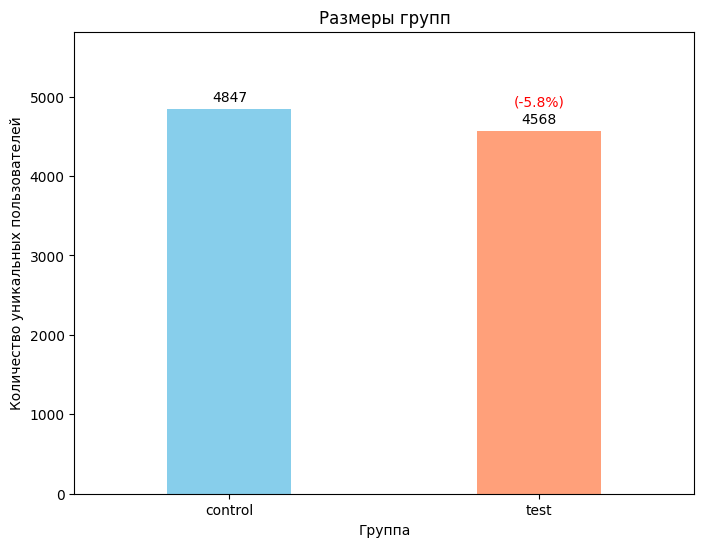

In [16]:

group_size = abt.groupby('group')['user_id'].nunique()
display(f"Размер группы A: {group_size['control']}", 
        f"Размер группы B: {group_size['test']}")

plot_group_comparison_bar(
    data=group_size,    
    title='Размеры групп', 
    ylabel='Количество уникальных пользователей', 
    colors=(color_A, color_B)
)


 **Небольшие расхождения в размерах выборок допустимы**

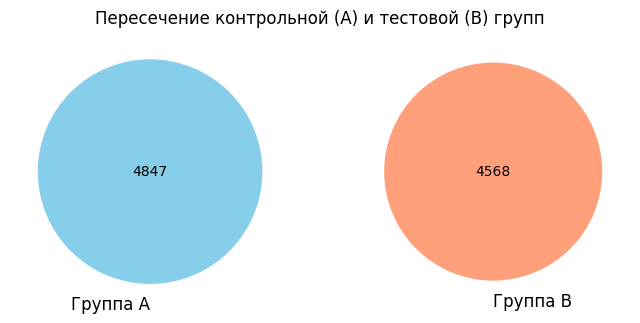

In [17]:
# Получаем уникальных пользователей
users_a = set(abt[abt['group']=='control']['user_id'])
users_b = set(abt[abt['group']=='test']['user_id'])

# Строим диаграмму Венна
plt.figure(figsize=(8,5))
v = venn2([users_a, users_b], set_labels=('Группа A', 'Группа B'), set_colors=(color_A, color_B))
# убираем прозрачность
[patch.set_alpha(1.0) for patch in v.patches if patch]
    
      
plt.title('Пересечение контрольной (A) и тестовой (B) групп')
plt.show()

**Пересечений выборок контрольной и тестовой групп нет**

#### 3.2. Сравнение воронок событий по группам

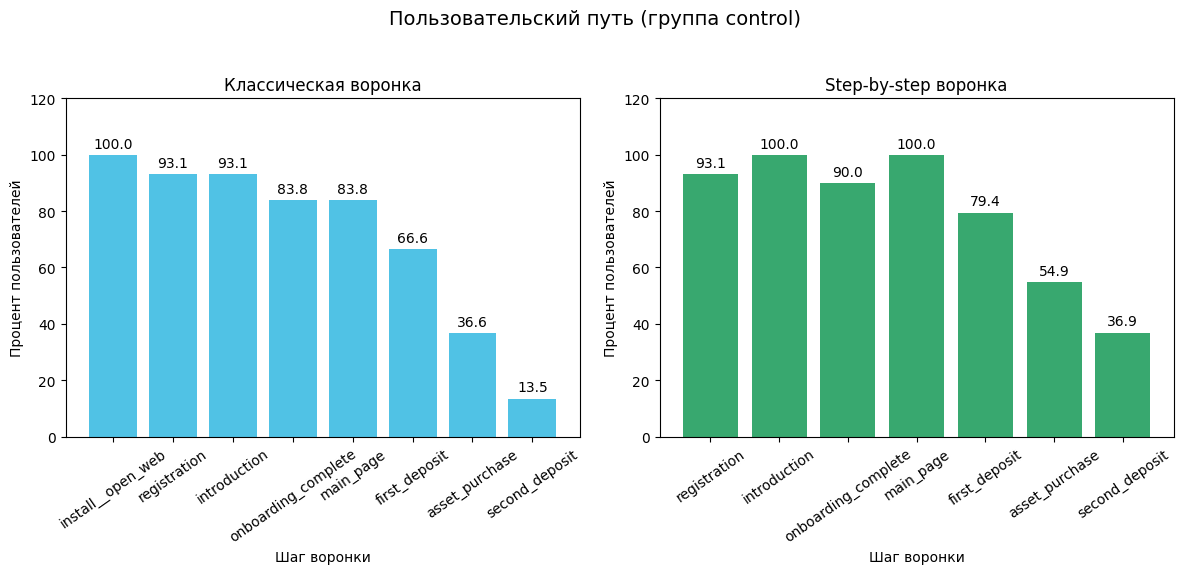

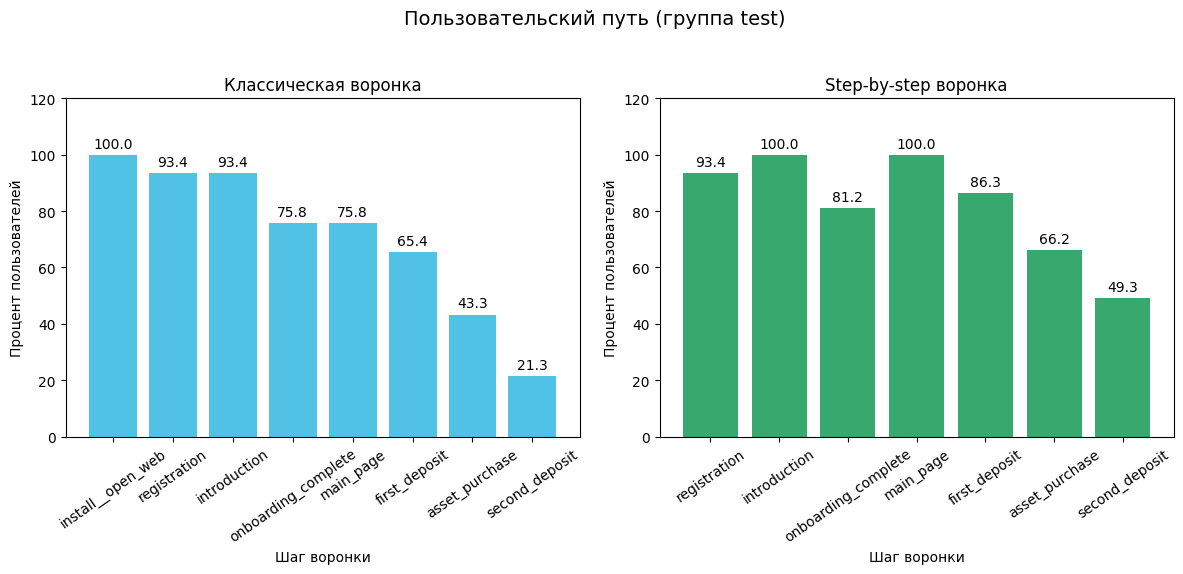

In [18]:
# шаги воронки 
fun_steps = [ 'install__open_web', 'registration', 'introduction', 
                'onboarding_complete', 'main_page', 'first_deposit', 
                'asset_purchase', 'second_deposit']

# добавляем дату
abt['event_dt'] =  abt['event_ts'].dt.normalize()

# сортируем данные
abt_sorted = abt.sort_values(['user_id', 'event_ts'])

# фильтруем по шагам
fun_step_data = abt_sorted[abt_sorted['event_name'].isin(fun_steps)]

# ------------------------------------------------------------------------------
# пользовательский путь нелинейный - поэтому воронку  
# считаем, фильтруя пользователей пришедших с предществующего шага
abt_funnels = {} # <-- пригодится нам при расчете барьерной метрики
for group in ['control', 'test']:
    group_data = fun_step_data[fun_step_data['group']==group] 
    prev_step_ids = set(group_data['user_id'])
    step_ids = {}
    for step in fun_steps:
        this_step_ids  = set(
            group_data[
                (group_data['event_name'] == step) &
                (group_data['user_id'].isin(prev_step_ids))
            ]['user_id']
        )
        step_ids[step] = len(this_step_ids)
        prev_step_ids = this_step_ids
    
    funnel = pd.DataFrame(step_ids.items(), columns=['step', 'usr_cnt'])
    
    # классич. и step by step воронки
    funnel['cr_from_first'] = funnel.loc[:, 'usr_cnt'] *100 / \
                                funnel.loc[0, 'usr_cnt'] 
    funnel['cr_from_prev'] = funnel.loc[:, 'usr_cnt'] *100 / \
                                funnel.shift(1)['usr_cnt']

    abt_funnels[group] = funnel  # <-- пригодится при расчете барьерной метрики
    # --------------------------------------------------------------------------
    # строии графики
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'Пользовательский путь (группа {group})', fontsize=14)

    for i, (met,title) in enumerate([('cr_from_first', 'Классическая'),
                                    ('cr_from_prev', 'Step-by-step')]):
        bars = ax[i].bar(funnel['step'], funnel[met], color=pal[i+1])
        
        
        ax[i].set_title(f'{title} воронка')
        ax[i].set_xlabel('Шаг воронки')
        ax[i].set_ylabel('Процент пользователей')
        ax[i].bar_label(bars, fmt='%.1f', padding=3)
        ax[i].tick_params(axis='x', labelrotation=35)
        ax[i].set_ylim(0, 120)
    
    # plt.tight_layout()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # print(f'Пользовательский путь (группа {group})')
    # print(funnel)

- **registration**: до онбординга конверсия практически одинаковая в обеих группах **(control 93.1%, test 93.4%)**  
- **onboarding_complete**: падение в тестовой группе **(control 90.0%, test 81.2%)**. Возможно, детальный и   
сложный онбординг действительно отпугивает часть пользователей. 
- **first_deposit**: конверсия из main_page в first_deposit в тесте выше, чем в контроле **(control 79.4%, test 86.3% )**
- **asset_purchase**: конверсия в покупку актива в тесте снова значительно выше **(control 54.9%, test 66.2% )**
- **second_deposit**: самый большой рост. Конверсия в второй депозит в тестовой группе почти на 12 п.п.   
выше **(control 36.9%,  test 49.3%)**

Наибольшее падение в тестовой группе происходит на этапе **onboarding_complete**. Оно составляет 19% от предыдущего   
шага (100% -> 81%). Возможно стоит подумать над тем как для этого этапа с одной стороны сбалансировать сложность и  
детализацию, а с другой информативность .  

Отсев на этапе онбординга оставляет более мотивированную аудиторию, что приводит к росту конверсии на последующих  
шагах воронки.

#### 3.3. Влияние онбординга на конверсию во второй депозит (в разрезе риска)

Количество пользователей до фильтрации 54805
Количество пользователей после фильтрации 6215


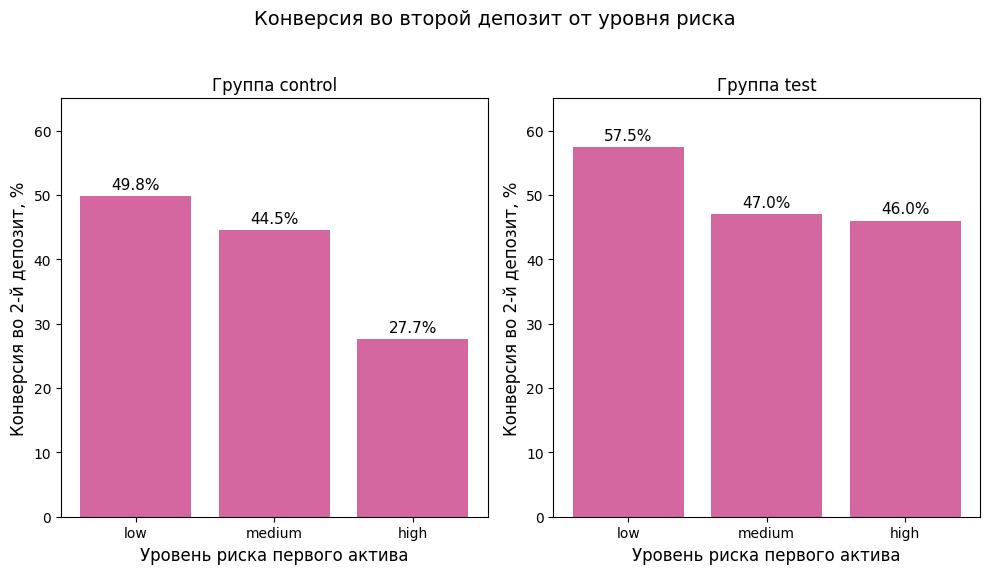

In [19]:
# находим всех у кого есть первый депозит
print('Количество пользователей до фильтрации', abt_sorted.shape[0])
first_depo_ids = abt[abt['event_name'] == 'first_deposit']['user_id']
print('Количество пользователей после фильтрации', first_depo_ids.shape[0])

filtered = abt[abt['user_id'].isin(first_depo_ids)]

# находим уровень риска пользователя  
user_rl = (
    filtered[filtered['event_name'] == 'asset_purchase']
    .groupby('user_id')['risk_level']
    .first()
    .reset_index()
    .rename(columns={'risk_level': 'user_risk_level'})
)
user_risk = abt.merge(user_rl, how='left', on='user_id')

# группируем пользователей по риску и считаем кол-во
risk_group_cnt = (
    user_risk
    .groupby(['event_name', 'group', 'user_risk_level'])['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'usr_cnt'})
)


fig, ax = plt.subplots(1, 2, figsize=(10, 6))
risk_order = ['low', 'medium', 'high']
cat_type = CategoricalDtype(categories=risk_order, ordered=True)

fig.suptitle(f'Конверсия во второй депозит от уровня риска', fontsize=14)
for i, group in enumerate(['control', 'test']):
    group_data = risk_group_cnt[risk_group_cnt['group']==group]
    
    # переформатиурем таблицу для удобства 
    risk_pt = group_data.pivot(
        columns=['event_name'],
        index='user_risk_level',
        values= 'usr_cnt'
    ).reset_index()

    # считаем конверсию
    risk_pt['cr_pct'] = 100 * risk_pt['second_deposit'] / risk_pt['first_deposit']

    # сделаем сортировку по риску
    risk_pt['user_risk_level'] = risk_pt['user_risk_level'].astype(cat_type)
    risk_pt = risk_pt.sort_values('user_risk_level')

    # ------------------------------------------------------------------------------
    # строим график
    bars = ax[i].bar(risk_pt['user_risk_level'], risk_pt['cr_pct'], color=pal[3])
    ax[i].set_title(f'Группа {group}')
    ax[i].set_xlabel('Уровень риска первого актива', fontsize=12)
    ax[i].set_ylabel('Конверсия во 2-й депозит, %', fontsize=12)
    ax[i].bar_label(bars, fmt='%.1f%%', padding=3, fontsize=11)
    ax[i].tick_params(axis='x', labelrotation=0)
    ax[i].set_ylim(0, 65)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

**Проверка гипотезы о равенстве долей (конверсий) по уровням риска**

Для каждого уровня риска (Low, Medium, High) проверяется следующая пара гипотез:
- **H₀ (Нулевая гипотеза):** Конверсии во второй депозит в тестовой и контрольной группах **равны**.
- **H₁ (Альтернативная гипотеза):** Конверсии во второй депозит в тестовой и контрольной группах **статистически значимо**  
**отличаются**  


In [20]:
# переформатируем таблицу
risk_pivot = risk_group_cnt.pivot_table(
    index=['user_risk_level', 'group'],
    columns='event_name',
    values='usr_cnt',
    fill_value=0
)

# проводим z-тесты

alpha = 0.05

print("Проверка стат. значимости для конверсии во второй депозит")

for risk_level in ['low', 'medium', 'high']:
    
    # Извлекаем числа для контрольной группы (A)
    control_data = risk_pivot.loc[(risk_level, 'control')]
    n_a = control_data.get('first_deposit', 0) # Испытания
    m_a = control_data.get('second_deposit', 0) # Успехи
    
    # Извлекаем числа для тестовой группы (B)
    test_data = risk_pivot.loc[(risk_level, 'test')]
    n_b = test_data.get('first_deposit', 0) # Испытания
    m_b = test_data.get('second_deposit', 0) # Успехи
    
    # Рассчитываем доли успехов
    p_a = m_a / (n_a)
    p_b = m_b / (n_b)
    
    # Проводим z-тест
    stat_ztest, p_val_ztest = proportions_ztest(
        [m_a, m_b], # <-- Порядок: тест, контроль
        [n_a, n_b],
        alternative='two-sided' 
    )
    
    # Формируем вывод
    res = ('<', 'ЗНАЧИМЫ') if p_val_ztest < alpha else ('>', 'не значимы')
    
    print(f"""
Уровень риска: {risk_level.upper()}
CR Control: {p_a:.2%} ({m_a} / {n_a})
CR Test:    {p_b:.2%} ({m_b} / {n_b})
P-value:    {p_val_ztest:.4f} {res[0]} {alpha}. Различия статистически {res[1]}.
""")

Проверка стат. значимости для конверсии во второй депозит

Уровень риска: LOW
CR Control: 49.82% (142.0 / 285.0)
CR Test:    57.46% (285.0 / 496.0)
P-value:    0.0391 < 0.05. Различия статистически ЗНАЧИМЫ.


Уровень риска: MEDIUM
CR Control: 44.54% (265.0 / 595.0)
CR Test:    47.04% (350.0 / 744.0)
P-value:    0.3607 > 0.05. Различия статистически не значимы.


Уровень риска: HIGH
CR Control: 27.66% (247.0 / 893.0)
CR Test:    46.00% (339.0 / 737.0)
P-value:    0.0000 < 0.05. Различия статистически ЗНАЧИМЫ.



**Контрольная группа (старый онбординг):**
- чем выше риск актива, тем ниже конверсия во второй депозит (low: **49.8%**, medium: **44.5%**, high: **27.7%**).
- результат согласуется с предположением о том, что пользователи, не понимая рисков, покупают рискованные активы 
и уходят из продукта.

**Тестовая группа (новый онбординг):**
- Конверсия выросла во всех сегментах.
- **high-risk**: наибольший рост: с 27.7% до 46.0% (18 п.п.). Это изменение **статистически значимо** (p-value < 0.001).
- **low-risk**: рост с 49.8% до 57.5% (7.5 п.п.) также является **статистически значимым** (p-value = 0.039).
- **medium-risk**: рост **статистически НЕ значим** (p-value = 0.361).

Новый онбординг **статистически значимо** решает проблему с низким удержанием "рискованных" пользователей (high-risk).  
Он также **статистически значимо** улучшает конверсию для самой осторожной группы (low-risk)
У клиентов со средним риском (medium-risk) не удалось зафиксировать статистически значимое изменение метрики.

Таким образом обучение отсеяло часть незамотивированных клиентов, а у остальных повысило лояльность и готовность  
пополнять второй депозит.  

#### 3.4. Статистический анализ метрик A/B-теста

#### Ключевая метрика (ARPU)

ARPU является ratio-метрикой, которая рассчитывается как **Сумма депозитов / Количество пользователей**.  
На уровне пользователя это отношение **Y(u) / X(u)**, где:
- **Y(u)**-это случайная величина, представляющая суммарный депозит пользователя
- **X(u)**-это знаменатель, который для каждого пользователя равен 1.

Поскольку знаменатель **X(u)** является константой, то формула линеаризации L(u) = Y(u) - k * X(u) превращается в  
L(u) = amount(u) - k * 1. Можно применять **стандартный t-тест**. 


**Проверка гипотезы о равенстве средних**

- **H₀ (Нулевая гипотеза):** Средние значения метрики в контрольной и тестовой группах **равны**.
- **H₁ (Альтернативная гипотеза):** Средние значения метрики в контрольной и тестовой группах **статистически значимо**  
**отличаются**.

In [21]:
# рассчитываем метрики 
arpu = abt.groupby('group').agg(
    total_deposits=('amount', 'sum'),
    total_users=('user_id', 'nunique')
)

# вычисляем ARPU
arpu['arpu'] = arpu['total_deposits'] / arpu['total_users']
arpu['abs_diff'] = arpu['arpu'].diff() 
arpu['rel_diff'] = arpu['arpu'].pct_change() * 100


# ------------------------------------------------------------------------------
# проверим значимость

# агрегируем данные на уровне пользателей и групп 
usr_data = abt.pivot_table(
    index=['user_id', 'group'], 
    values='amount',
    aggfunc='sum',
    fill_value=0
).reset_index()
    
# разобъем на группы
control = usr_data[usr_data['group'] == 'control']['amount']
test = usr_data[usr_data['group'] == 'test']['amount']

# применяем t-тест (можем потому что в знаменателе 1)
t_stat, p_value = stats.ttest_ind(
    test, 
    control, 
    equal_var=False
)

alpha = 0.05

# ------------------------------------------------------------------------------
# выводим результат
res = ('>',  'не ') if p_value > alpha else ('<', '')

print(f"""
Ключевая метрика ARPU:
  - Абсолютное изменение: {arpu.loc['test', 'abs_diff']:+.2f}
  - Относительное изменение: {arpu.loc['test', 'rel_diff']:+.2f}%

T-статистика: {t_stat:.3f}
P-value: {p_value:.3f} {res[0]} {alpha}

Вывод: Различия статистически {res[1]}значимы
"""      
)




Ключевая метрика ARPU:
  - Абсолютное изменение: +2.22
  - Относительное изменение: +2.46%

T-статистика: 0.958
P-value: 0.338 > 0.05

Вывод: Различия статистически не значимы



**Прирост ARPU в тестовой группе есть  +2.22 (отн. изм. +2.46%), но различия статистически не значимы -  p-value = 0.338** 

#### Барьерная метрика (CR в первый депозит)

**Проверка гипотезы о равенстве долей (конверсий)**

- **H₀ (Нулевая гипотеза):** Конверсии в контрольной и тестовой группах **равны**.
- **H₁ (Альтернативная гипотеза):** Конверсии в контрольной и тестовой группах **статистически значимо отличаются**.


In [22]:
# ранее мы завели словарь с воронками abt_funnels
# переобозначим чтобы сделать код чище
fun = abt_funnels

# сделаем поле step индексом
[v.set_index('step', inplace=True) for v in fun.values() if 'step' in v.columns] 

# количество испытаний A и B
n_a = fun['control'].loc['registration', 'usr_cnt']
n_b = fun['test'].loc['registration', 'usr_cnt']

# количество успехов A и B
m_a = fun['control'].loc['first_deposit', 'usr_cnt']
m_b = fun['test'].loc['first_deposit', 'usr_cnt']

# рассчитываем доли успехов (вероятности)
p_a, p_b = m_a/n_a, m_b/n_b 

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')


# ------------------------------------------------------------------------------
alpha = 0.05 

stat_ztest, p_val_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='two-sided' 
)

# ------------------------------------------------------------------------------
# выводим результат
res = ('>', '') if p_val_ztest > alpha else ('<', 'не ')

print(f"""
n_a={n_a},  n_b={n_b}
m_a={m_a},  m_b={m_b}
p_a={p_a:.4f},  p_b={p_b:.4f}
    
Конверсия в контроле: {p_a:.2%}
Конверсия в тесте: {p_b:.2%}

P-value: {p_val_ztest:.6f} {res[0]} {alpha}
Нулевая гипотеза {res[1]}находит подтверждение!
"""      
)


Предпосылка о достаточном количестве данных выполняется!

n_a=4512,  n_b=4265
m_a=3228,  m_b=2987
p_a=0.7154,  p_b=0.7004

Конверсия в контроле: 71.54%
Конверсия в тесте: 70.04%

P-value: 0.120543 > 0.05
Нулевая гипотеза находит подтверждение!



**Гипотеза H1 о различии барьерной метрики (конверсия из регистрации в первый депозит) в контрольной и тестовой группе не**  
**нашла подтверждения.**

#### Вспомогательная метрика 1 (CR во второй депозит)

**Проверка гипотезы о равенстве долей (конверсий)**

- **H₀ (Нулевая гипотеза):** Конверсии в контрольной и тестовой группах **равны**.
- **H₁ (Альтернативная гипотеза):** Конверсии в контрольной и тестовой группах **статистически значимо отличаются**.


In [23]:
# количество испытаний A и B
n_a = fun['control'].loc['first_deposit', 'usr_cnt']
n_b = fun['test'].loc['first_deposit', 'usr_cnt']

# количество успехов A и B
m_a = fun['control'].loc['second_deposit', 'usr_cnt']
m_b = fun['test'].loc['second_deposit', 'usr_cnt']

# рассчитываем доли успехов (вероятности)
p_a, p_b = m_a/n_a, m_b/n_b 

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')


# ------------------------------------------------------------------------------
alpha = 0.05 

stat_ztest, p_val_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='two-sided' 
)

# ------------------------------------------------------------------------------
# выводим результат
res = ('>', '') if p_val_ztest > alpha else ('<', 'не ')

print(f"""
n_a={n_a},  n_b={n_b}
m_a={m_a},  m_b={m_b}
p_a={p_a:.4f},  p_b={p_b:.4f}
    
Конверсия в контроле: {p_a:.2%}
Конверсия в тесте: {p_b:.2%}

P-value: {p_val_ztest:.6f} {res[0]} {alpha}
Нулевая гипотеза {res[1]}находит подтверждение!
"""      
)


Предпосылка о достаточном количестве данных выполняется!

n_a=3228,  n_b=2987
m_a=654,  m_b=974
p_a=0.2026,  p_b=0.3261

Конверсия в контроле: 20.26%
Конверсия в тесте: 32.61%

P-value: 0.000000 < 0.05
Нулевая гипотеза не находит подтверждение!



**Поскольку p-value < 0.05, отвергаем нулевую гипотезу о равенстве конверсий из первого депозита во второй.**

#### Вспомогательная метрика 2 (ARPPU)
(расчет аналогично ARPU, только теперь учитываются только платящие пользователи)

**Проверка гипотезы о равенстве средних**

- **H₀ (Нулевая гипотеза):** Средние значения метрики в контрольной и тестовой группах **равны**.
- **H₁ (Альтернативная гипотеза):** Средние значения метрики в контрольной и тестовой группах **статистически значимо**  
**отличаются**.

In [24]:
# агрегируем данные на уровне пользователей 
usr_data = abt.pivot_table(
    index=['user_id', 'group'], 
    values='amount',
    aggfunc='sum',
    fill_value=0
).reset_index()

# фильтруем платящих
paying_users = usr_data[usr_data['amount'] > 0]

# агрегируем группы 
arppu = paying_users.groupby('group').agg(
    total_deposits=('amount', 'sum'),
    paying_users=('user_id', 'nunique')
)

# вычисляем ARPPU
arppu['arppu'] = arppu['total_deposits'] / arppu['paying_users']
arppu['abs_diff'] = arppu['arppu'].diff() 
arppu['rel_diff'] = arppu['arppu'].pct_change() * 100

# ------------------------------------------------------------------------------
# проверим значимость
alpha = 0.05
# разобъем на группы
control = paying_users[paying_users['group'] == 'control']['amount']
test = paying_users[paying_users['group'] == 'test']['amount']

# применяем t-тест (т. Уэлча)
t_stat, p_value = stats.ttest_ind(
    test, 
    control, 
    equal_var=False
)

res = ('>',  'не ') if p_value > alpha else ('<', '')

# ------------------------------------------------------------------------------
# выводим результат
print(f"""
Вспомогательная метрика 2 - ARPPU:

Абсолютное изменение: {arppu.loc['test', 'abs_diff']:+.2f}
Относительное изменение: {arppu.loc['test', 'rel_diff']:+.2f}%
      
T-статистика: {t_stat:.3f}
P-value: {p_value:.3f} {res[0]} {alpha}
Вывод: Различия статистически {res[1]}значимы
"""      
)



Вспомогательная метрика 2 - ARPPU:

Абсолютное изменение: +5.90
Относительное изменение: +4.35%

T-статистика: 2.054
P-value: 0.040 < 0.05
Вывод: Различия статистически значимы



**Поскольку p-value < 0.05, отвергаем нулевую гипотезу о равенстве средних. Значения метрики ARPPU статистически значимо**   
**отличаются в контрольной и тестовой группе**

#### Накопленная динамика изменения по дням эксперимента для каждой группы и стабильность p-value во время эксперимента.

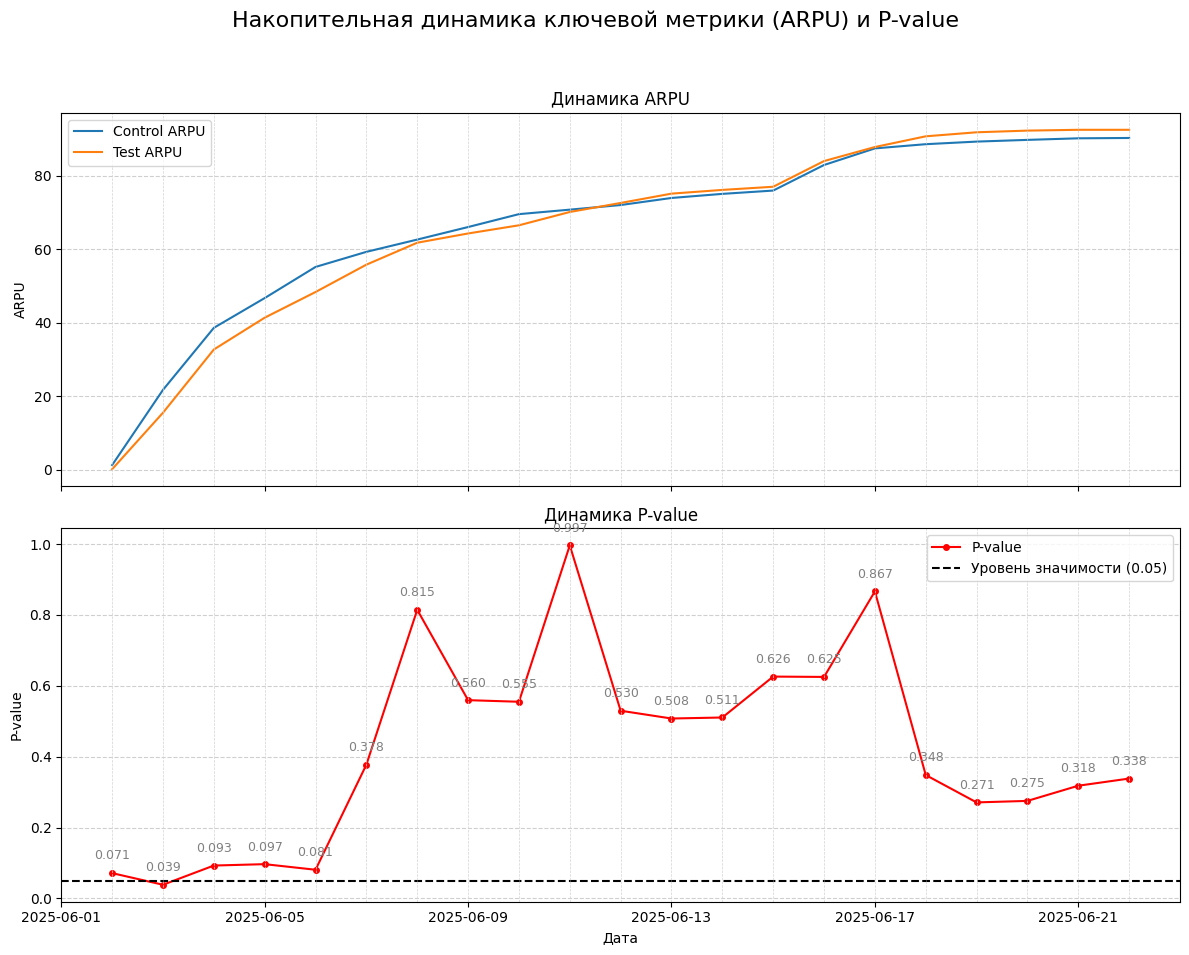

In [ ]:

# пользователь-группа
user_group = abt[['user_id', 'group']].drop_duplicates().set_index('user_id')

# получаем уникальные отсортированные даты эксперимента
daily_dates = sorted(abt['event_dt'].unique())

# списки для хранения накоплений
cum_results = []

# итерируемся по дням
for current_date in daily_dates:
    # фильтруем данные
    cum_data = abt[abt['event_dt'] <= current_date]
    
    # ARPU 
    metrics = cum_data.groupby('group').agg(
        total_deposits=('amount', 'sum'),
        total_users=('user_id', 'nunique')
    )
    metrics['arpu'] = metrics['total_deposits'] / metrics['total_users']
    
    # p-value
    # считаем кум. суммы только для активных
    user_cumulative_sum = cum_data.groupby('user_id')['amount'].sum()
    
    # присоединяем кум. суммы ко всем
    full_user_data = user_group.join(user_cumulative_sum).fillna(0)
    
    # тест на ПОЛНЫХ данных
    control_amounts = full_user_data[full_user_data['group'] == 'control']['amount']
    test_amounts = full_user_data[full_user_data['group'] == 'test']['amount']
    
    t_stat, p_value = stats.ttest_ind(
        test_amounts, 
        control_amounts, 
        equal_var=False
    )
    
    # user_level_df = cum_data.pivot_table(
    #     index='user_id', columns='group', values='amount',
    #     aggfunc='sum', fill_value=0
    # )
    
    # t_stat, p_value = stats.ttest_ind(
    #     user_level_df['test'], 
    #     user_level_df['control'], 
    #     equal_var=False
    # )
    
    # сохраняем результаты
    cum_results.append({
        'date': current_date,
        'arpu_control': metrics.loc['control', 'arpu'],
        'arpu_test': metrics.loc['test', 'arpu'],
        'p_value': p_value
    })

# преобразуем в df
results = pd.DataFrame(cum_results)


# ------------------------------------------------------------------------------
# строим графики
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Накопительная динамика ключевой метрики (ARPU) и P-value', fontsize=16)

# ARPU
axs[0].plot(results['date'], results['arpu_control'], label='Control ARPU')
axs[0].plot(results['date'], results['arpu_test'], label='Test ARPU')
axs[0].set_title('Динамика ARPU')
axs[0].set_ylabel('ARPU')
axs[0].legend()
axs[0].grid(True, axis='y', linestyle='--', alpha=0.6)

# P-value
axs[1].plot(results['date'], results['p_value'], label='P-value', color='red', 
            marker= 'o', markersize=4)
axs[1].axhline(0.05, color='black', linestyle='--', label='Уровень значимости (0.05)')
axs[1].set_title('Динамика P-value')
axs[1].set_xlabel('Дата')
axs[1].set_ylabel('P-value')
axs[1].legend()
axs[1].grid(True, axis='y', linestyle='--', alpha=0.6)
# Добавление значений рядом с каждой точкой
for x, y in zip(results['date'], results['p_value']):
    axs[1].text(x, y+ 0.03, f'{y:.3f}', fontsize=9, 
                ha='center', va='bottom', color='grey')



# Добавляем вертикальные линии вручную на оба графика
for date in results['date']:
    axs[0].axvline(x=date, color='lightgrey', linestyle='--', linewidth=0.5)
    axs[1].axvline(x=date, color='lightgrey', linestyle='--', linewidth=0.5)

plt.xticks(rotation=0)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()  

# print(results)

- Накопительный ARPU для обеих групп растет со временем, при этом кривая теста в итоге незначительно обгоняет контроль.
- График p-value после начального периода колебаний **стабилизируется значительно выше** уровня 0.05.
- Это говорит о том, что наблюдаемая разница в ARPU является **стабильно незначимой** на протяжении большей части  
эксперимента.

Несмотря на стабильный результат, **проверка мощности остается актуальной**, чтобы подтвердить, что наш тест был  
достаточно сильным, чтобы мы могли доверять полученному результату.

#### Мощность

In [26]:
# размеры групп (всех пользователей)
n_control = abt[abt['group'] == 'control']['user_id'].nunique()
n_test = abt[abt['group'] == 'test']['user_id'].nunique()

# данные по суммам депозитов для всех пользователей (включая нули)
usr_data = abt.pivot_table(
    index='user_id', 
    columns='group',
    values='amount',
    aggfunc='sum',
    fill_value=0
)
control_amounts = usr_data['control']
test_amounts = usr_data['test']

# эффект, который хотим измерить (стандартизированный)
# Это разница средних, деленная на объединенное стандартное отклонение
# Называется "d Коэна"
mean_diff = test_amounts.mean() - control_amounts.mean()
std_control = control_amounts.std(ddof=1)
std_test = test_amounts.std(ddof=1)

# объединенное стандартное отклонение
pooled_std = np.sqrt(
    ((n_control - 1) * std_control**2 + (n_test - 1) * std_test**2) / 
    (n_control + n_test - 2)
)

effect_size = mean_diff / pooled_std

alpha = 0.05
# соотношение размеров выборок
ratio = n_test / n_control

# инициализируем класс для анализа мощности
power_analyzer = TTestIndPower()

# рассчитываем мощность
power = power_analyzer.solve_power(
    effect_size=effect_size, # какой эффект мы ищем
    nobs1=n_control,         # размер первой выборки
    alpha=alpha,             # уровень значимости
    ratio=ratio,             # соотношение выборок
    power=None,              # этот параметр мы и хотим найти
    alternative='two-sided'
)

res_str = ("Мощность теста достаточна.", 
           "Мощность теста ниже 80%. Вероятна ошибка II рода.")
conclusion_text = res_str[0] if power >= 0.8 else res_str[1]

print(f"""
- Размер эффекта (d Коэна): {effect_size:.4f}
- Мощность теста: {power:.2%}

Вывод: {conclusion_text}
""")


- Размер эффекта (d Коэна): -0.0177
- Мощность теста: 13.77%

Вывод: Мощность теста ниже 80%. Вероятна ошибка II рода.



**Мощность теста получилась 13.77%,** что является крайне низким значением. Типовые значения обычно находятся   
около 80%. Что означает, что велика вероятность ошибки II рода - не обнаружить эффект если он есть. По этой причине  
**отсутствие стат. значимого прироста ключевой метрики не должно быть причиной отказа от внедрения новой фичи**. 

**Необходимо провести более масштабное исследование с большим объёмом выборки и более длительным периодом   
проведения эксперимента. Это позволит повысить мощность теста и получить более достоверные результаты.**


---

### 4. Анализ изменений суммы депозитов на платящего пользователя

In [27]:
# ⚠️ у нас уже есть amount по группам 
# они хранятся в переменных control и test
# print(control, test) 


# 42 - классика
np.random.seed(42)

n_iterations = 1000
bootstrap_results = {}
for pctl in (25, 50, 75):
    boot_diffs = []
    
    # Бутстрап-разница i-х перцентилей между тестовой и контрольной группами
    for i in tqdm(range(n_iterations)):
        boot_control = np.random.choice(control, size=len(control), replace=True)
        boot_test = np.random.choice(test, size=len(test), replace=True)

        # Для расчёта i-го перцентиля используем .percentile() из библиотеки numpy 
        control_pctl = np.percentile(boot_control, pctl)
        test_pctl = np.percentile(boot_test, pctl)

        # Находим разницу между значениями тестовой и контрольной групп
        boot_diffs.append(test_pctl - control_pctl)

    # Создаём массив разниц между 95-ми перцентилями тестовой и контрольной групп
    boot_diffs = np.array(boot_diffs)
    # складываем в словарь
    bootstrap_results[pctl] = boot_diffs

    # Доверительный интервал разницы между 95-ми перцентилями (перцентильный метод)
    diff_ci = np.percentile(boot_diffs, [2.5, 97.5])

    # Вывод доверительного интервала
    print(f"""
    {pctl}-й перцентиль контрольной группы: {np.percentile(control, pctl):.2f}
    {pctl}-й перцентиль тестовой группы: {np.percentile(test, pctl):.2f}
    95%-й доверительный интервал разности {pctl}-х перцентилей [{diff_ci[0]:.2f}, {diff_ci[1]:.2f}]
    """)


100%|██████████| 1000/1000 [00:00<00:00, 3761.85it/s]



    25-й перцентиль контрольной группы: 95.00
    25-й перцентиль тестовой группы: 48.00
    95%-й доверительный интервал разности 25-х перцентилей [-50.00, -44.00]
    


100%|██████████| 1000/1000 [00:00<00:00, 3764.34it/s]



    50-й перцентиль контрольной группы: 118.00
    50-й перцентиль тестовой группы: 94.00
    95%-й доверительный интервал разности 50-х перцентилей [-27.01, -19.00]
    


100%|██████████| 1000/1000 [00:00<00:00, 3952.36it/s]


    75-й перцентиль контрольной группы: 159.00
    75-й перцентиль тестовой группы: 179.50
    95%-й доверительный интервал разности 75-х перцентилей [11.00, 30.00]
    


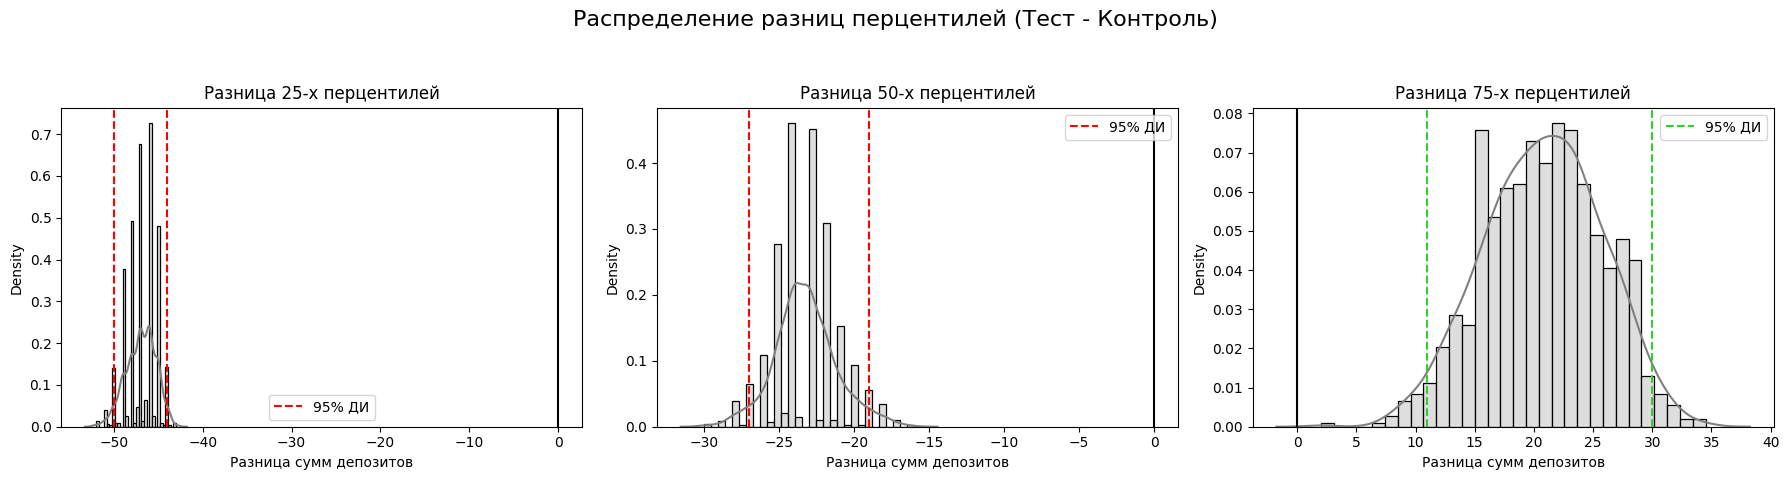

In [28]:
# строим графики
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Распределение разниц перцентилей (Тест - Контроль)', fontsize=16)

colors = ['red', 'red', 'limegreen']

for ax, pctl, color in zip(axs, bootstrap_results.keys(), colors):
    diffs = bootstrap_results[pctl]
    
    # считаем ДИ
    ci = np.percentile(diffs, [2.5, 97.5])
    
    sns.histplot(diffs, ax=ax, bins=30, color='lightgray', kde=False, stat='density')
    sns.kdeplot(diffs, color='gray', ax=ax)

    ax.axvline(ci[0], color=color, linestyle='--', label=f'95% ДИ')
    ax.axvline(ci[1], color=color, linestyle='--')
    ax.axvline(0, color='black', linestyle='-')
    
    ax.set_title(f'Разница {pctl}-x перцентилей')
    ax.set_xlabel('Разница сумм депозитов')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()


**25-й перцентиль (менее обеспеченные/осторожные пользователи):**
- Контроль 95, Тест 48.
- Доверительный интервал разницы (test - control): [-50.00, -44.00].
- Интервал отрицательной, ноль не включает ➡️ **Cнижение статистически значимо**. 
- Пользователи с небольшими депозитами стали вносить **значительно меньше** денег.

**50-й перцентиль (медиана, "типичный" пользователь):**
- Контроль 118, Тест 94.
- Доверительный интервал разницы: [-27.01, -19.00].
- Интервал отрицательной, ноль не включает ➡️ **Cнижение статистически значимо**.  
- "Типичный" пользователь в тестовой группе также стал вносить **меньше** денег.
-  Вероятно, часть "средних" пользователей, получив больше информации о рисках, решила начать с меньшей суммы, что и   
привело к смещению медианы вниз.


**75-й перцентиль (более обеспеченные/рисковые пользователи):**
- Контроль 159, Тест 179.5.
- Доверительный интервал разницы: [11.00, 30.00].
- Интервал положительный, ноль не включает ➡️ **Рост статистически значим**. 
- Пользователи с крупными инвестициями стали вносить **значительно больше** денег.


Новый онбординг произвел **эффект поляризации**:
-  **отпугнул "осторожную" часть аудитории** (нижние 25% и медиана), которая стала вносить меньше денег.
-  **мотивировал и сильнее вовлек "состоятельную" часть аудитории** (верхние 25%), которая стала вносить больше.

Это объясняет, почему общий ARPU не показал значимого роста - негативный эффект на одной части аудитории был   
скомпенсирован позитивным эффектом на другой.



---

### Выводы


#### Основные результаты:

**Фильтрация нецелевого трафика:**
- Новый онбординг работает как фильтр. Он усложняет путь вначале (конверсия в завершение онбординга упала), но  
это отсеивает менее мотивированную аудиторию.
- Барьерная метрика (CR в 1-й депозит) при этом не просела **статистически значимо**, что снимает основные опасения.

**Рост качества аудитории:**
- Пользователи, прошедшие новый онбординг, показывают **значительно лучшее удержание и вовлеченность**.
- CR во 2-й депозит: Статистически значимый рост с 20.3% до 32.6% в целом.
- ARPPU (средний чек платящего): Статистически значимый рост на +4.35%.

**Решение ключевой проблемы:**
- Новый онбординг решил проблему удержания пользователей, выбравших **высокорискованные активы**. 
- Конверсия в повторный депозит для них **статистически значимо взлетела** с 28% до 46%.

**Разнонаправленное движение:**
- Новая фича по-разному повлияла на разные сегменты: 
    - пользователи с небольшими депозитами стали вносить **статистически значимо меньше**, 
    - пользователи с крупными-**статистически значимо больше**. 
- Это объясняет почему общий ARPU не показал роста - эффекты скомпенсировались.

#### Рекомендации:
1. Внедрить обновленный онбординг. Несмотря на то, что ключевая метрика (ARPU) не показала статистически значимого   
роста, эксперимент выявил сильные положительные эффекты, которые перевешивают риски. **Улучшение** качества аудитории и  
решение проблемы с "high-risk" пользователями перевешивают риски.
Отсутствие прироста ключевой метрики не является надежным результатом, поскольку низкая мощность теста (всего 14%) 
не позволяет сделать уверенный вывод об отсутствии эффекта (высока вероятность ошибки II рода) и потому это не должно   
служить аргументом против внедрения фичи.
2. Чтобы выяснить есть ли на самом деле рост ARPU рекомендуется провести более масштабный эксперимент на большей  
выборке или на более длительном сроке.
3. Проанализировать и сбалансировать этап онбординга сделав его менее сложным без потери информативности.